# **Skenario 3 - CNN MobileNetV2**

Skenario 3 menggunakan model Convolutional Neural Network (CNN) dengan arsitektur MobileNetV2 untuk melakukan klasifikasi pada data citra otak.

---

## 1. Import packages

Impor semua pustaka dan modul yang dibutuhkan untuk pemrosesan data, visualisasi, pembuatan model, dan pelatihan model

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import os
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import pickle

# Scikit-learn importspython
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import KFold

# TensorFlow and Keras imports
import tensorflow as tf
from keras.utils import to_categorical
from keras.applications import MobileNetV2
from keras.layers import Input, GlobalAveragePooling2D, Dense
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import layers, models, optimizers

## 2. Data Preparation

### 2.1 Load dan Eksplorasi Data
Load dan proses data `image_selected.npz`

In [3]:
def load_and_preprocess_data(preprocess_images=True):
    base_dir = r"D:\Users\RESA\Coding\Alzheimer-Classification-with-CNN-SVM\Notebook\Preprocessing\image_selected.npz"
    
    # Load data from the NPZ file
    loaded_data = np.load(base_dir, allow_pickle=True)
    loaded_combined_slices = loaded_data[list(loaded_data.keys())[0]]

    # Prepare lists for input (X) and output (Y) data
    X = []
    Y = []

    # Create a label mapping for each class
    label_mapping = {'AD': 0, 'CN': 1, 'EMCI': 2, 'LMCI': 3}

    # Iterate through the loaded data
    for label, plane_slices in loaded_combined_slices.item().items():
        for plane, slices in plane_slices.items():
            for selected_slice in slices:
                position, original_slice = selected_slice

                if preprocess_images:
                    # Expand dimensions and repeat for RGB representation
                    original_slice = np.expand_dims(original_slice, axis=-1)
                    original_slice = np.repeat(original_slice, 3, axis=-1)

                    # Min-Max Scaling to bring pixel values to the range [0, 1]
                    min_val = np.min(original_slice)
                    max_val = np.max(original_slice)
                    original_slice = (original_slice - min_val) / (max_val - min_val)

                X.append(original_slice)
                Y.append(label_mapping[label])

    # Convert lists to NumPy arrays
    X = np.array(X) 
    Y = np.array(Y)

    # Convert labels to categorical format
    Y = to_categorical(Y, num_classes=len(set(Y)))

    return X, Y

In [4]:
# Panggil fungsi dan simpan ke X, Y
X, Y = load_and_preprocess_data(preprocess_images=True)

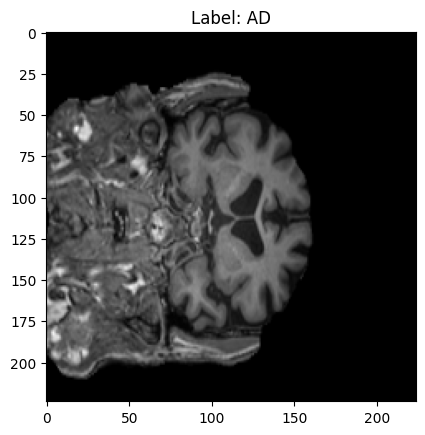

In [5]:
index_to_visualize = 3
image_to_visualize = X[index_to_visualize]
label_to_visualize = Y[index_to_visualize]

class_names = {0: 'AD', 1: 'CN', 2: 'EMCI', 3: 'LMCI'}
label_to_visualize = class_names[np.argmax(label_to_visualize)]

plt.imshow(image_to_visualize)
plt.title(f"Label: {label_to_visualize}")
plt.imshow(image_to_visualize, cmap='gray')

In [6]:
unique_labels, counts = np.unique(np.argmax(Y, axis=1), return_counts=True)
class_distribution = dict(zip(tuple(unique_labels), counts))

print("Distribusi Kelas setelah One-Hot Encoding:")
print(class_distribution)

Distribusi Kelas setelah One-Hot Encoding:
{0: 1800, 1: 1800, 2: 1800, 3: 1800}


### 2.2 Pembagian Data
Data dibagi dengan rasio 80:20 

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

cek shape dan jumlah data

In [8]:
print("Dimensi X_train:", X_train.shape)
print("Dimensi Y_train:", Y_train.shape)
print("Dimensi X_test:", X_test.shape)
print("Dimensi Y_test:", Y_test.shape)

Dimensi X_train: (5760, 224, 224, 3)
Dimensi Y_train: (5760, 4)
Dimensi X_test: (1440, 224, 224, 3)
Dimensi Y_test: (1440, 4)


## 3. Buat dan Konfigurasi Model
Arsitektur yang digunakan yaitu MobileNetV2 sebagai bagian dari transfer learning yaitu arsitektur yang sudah dilatih dengan data ImageNet

In [9]:
%%time
inputs = Input(shape=(224, 224, 3))

# Use MobileNetV2 as a layer in your model
def create_model():
    inputs = Input(shape=(224, 224, 3))
    base_model = MobileNetV2(
        weights='imagenet',
        input_tensor=inputs,
        include_top=False,
        input_shape=(224, 224, 3) 
    )
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    outputs = Dense(4, activation='softmax')(x)

    model = Model(inputs, outputs)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

CPU times: total: 0 ns
Wall time: 0 ns


In [10]:
# Use MobileNetV2 as a layer in your model
model = create_model()

# Display the model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │       0 │ -                    │
│ (InputLayer)        │ 3)                │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │     864 │ input_layer_1[0][0]  │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │     128 │ Conv1[0][0]          │
│ (BatchNormalizatio… │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │       0 │ bn_Conv1[0][0]       │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │     288 │ Conv1_relu[0][0]     │
│ (DepthwiseConv2D)   │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │     128 │ expanded_conv_depth… │
│ (BatchNormalizatio… │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │       0 │ expanded_conv_depth… │
│ (ReLU)              │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │     512 │ expanded_conv_depth… │
│ (Conv2D)            │ 16)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │      64 │ expanded_conv_proje… │
│ (BatchNormalizatio… │ 16)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block_1_expand      │ (None, 112, 112,  │   1,536 │ expanded_conv_proje… │
│ (Conv2D)            │ 96)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │     384 │ block_1_expand[0][0] │
│ (BatchNormalizatio… │ 96)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │       0 │ block_1_expand_BN[0… │
│ (ReLU)              │ 96)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block_1_pad         │ (None, 113, 113,  │       0 │ block_1_expand_relu… │
│ (ZeroPadding2D)     │ 96)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │     864 │ block_1_pad[0][0]    │
│ (DepthwiseConv2D)   │ 96)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │     384 │ block_1_depthwise[0… │
│ (BatchNormalizatio… │ 96)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │       0 │ block_1_depthwise_B… │
│ (ReLU)              │ 96)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block_1_project     │ (None, 56, 56,    │   2,304 │ block_1_depthwise_r

 Total params: 4,096,580 (15.63 MB)

 Trainable params: 1,838,596 (7.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

## 4. Training Model
Latih model dengan data `X_train dan Y_train` dan menguji kinerja model pada data validasi `X_test dan Y_test`, setelah pelatihan nanti model akan menyimpan riwayatnya ke dalam `h_model`

In [11]:
# Fine-tuning
EPOCH = 25
BATCH_SIZE = 16
h_model = model.fit(X_train, Y_train, epochs=EPOCH, validation_data=(X_test, Y_test), batch_size=BATCH_SIZE)

Epoch 1/25


## 5. Testing

### 5.1 Menilai model pada data uji

In [ ]:
# Evaluasi model menggunakan data uji NumPy
evaluation_result = model.evaluate(X_test, Y_test, verbose=1)

# Menampilkan hasil evaluasi
print("Loss:", evaluation_result[0])
print("Accuracy:", evaluation_result[1])

# Prediksi menggunakan data uji
predictions = model.predict(X_test)
predicted_labels = tf.argmax(predictions, axis=1).numpy()

print('Label Sebenarnya : ', np.argmax(Y_test, axis=1))
print('Label Prediksi : ', predicted_labels)

45/45 [==============================] - 7s 137ms/step - loss: 0.9622 - accuracy: 0.7785
Loss: 0.9621620178222656
Accuracy: 0.7784722447395325
45/45 [==============================] - 8s 136ms/step
Label Sebenarnya :  [1 1 2 ... 3 1 1]
Label Prediksi :  [1 1 2 ... 1 1 2]


### 5.2 Visualisasi beberapa gambar dari data uji
Membuat visualisasi dari beberapa contoh hasil prediksi model pada data test

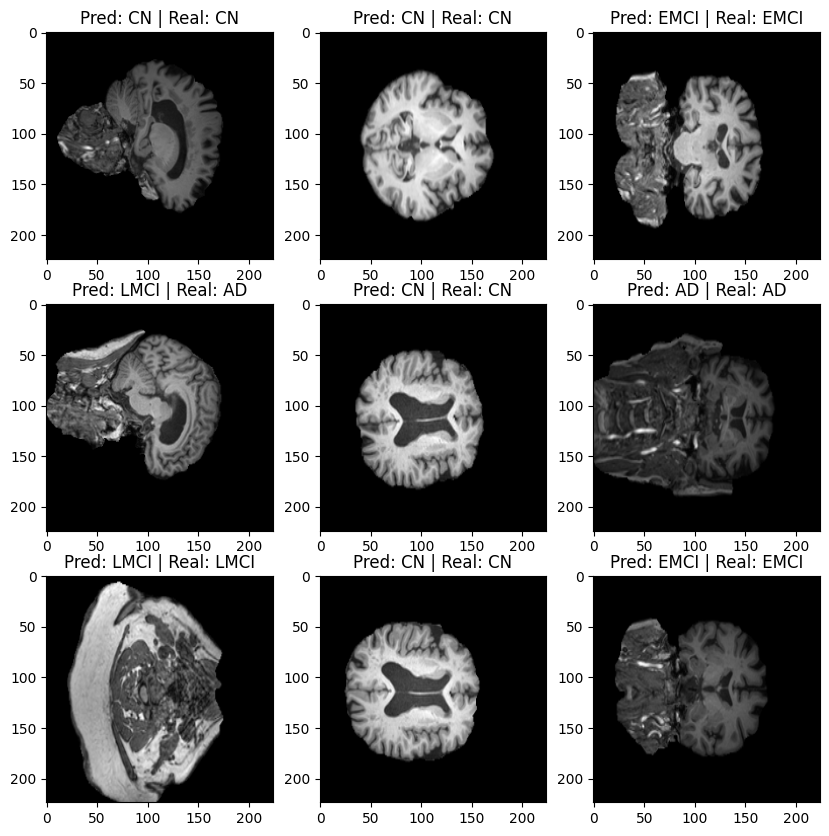

In [ ]:
class_names = ["AD", "CN", "EMCI", "LMCI"]

plt.figure(figsize=(10, 10))
for i in range(min(9, len(X_test))):
    ax = plt.subplot(3, 3, i + 1)
    # plt.imshow(X_test[i].astype("int64"))
    plt.imshow(X_test[i],cmap="gray")
    
    # Dapatkan label prediksi dan label sebenarnya
    true_label = np.argmax(Y_test[i])
    plt.title("Pred: " + class_names[predicted_labels[i]] + " | Real: " + class_names[true_label])

plt.show()

## 6. Evaluasi

### 6.1 Matriks specificity dan sensitivity

In [ ]:
from keras import backend as K

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', specificity, sensitivity])

Evaluasi model pada data train

In [ ]:
loss, accuracy, specificity, sensitivity = model.evaluate(X_train, Y_train)
print('Loss train set: ', loss)
print('Akurasi train set: ', accuracy)
print('Specificity train set: ', specificity)
print('Sensitivity train set: ', sensitivity)

180/180 [==============================] - 25s 135ms/step - loss: 0.1314 - accuracy: 0.9564 - specificity: 0.9865 - sensitivity: 0.9538
Loss train set:  0.13139858841896057
Akurasi train set:  0.9564236402511597
Specificity train set:  0.9865162372589111
Sensitivity train set:  0.9538194537162781


Evaluasi model pada data test

In [ ]:
loss, accuracy, specificity, sensitivity = model.evaluate(X_test, Y_test)
print('Loss train set: ', loss)
print('Akurasi train set: ', accuracy)
print('Specificity train set: ', specificity)
print('Sensitivity train set: ', sensitivity)

45/45 [==============================] - 6s 136ms/step - loss: 0.9622 - accuracy: 0.7785 - specificity: 0.9289 - sensitivity: 0.7764
Loss train set:  0.9621620178222656
Akurasi train set:  0.7784722447395325
Specificity train set:  0.9289352297782898
Sensitivity train set:  0.7763888835906982


Visualisasi confusion matrix

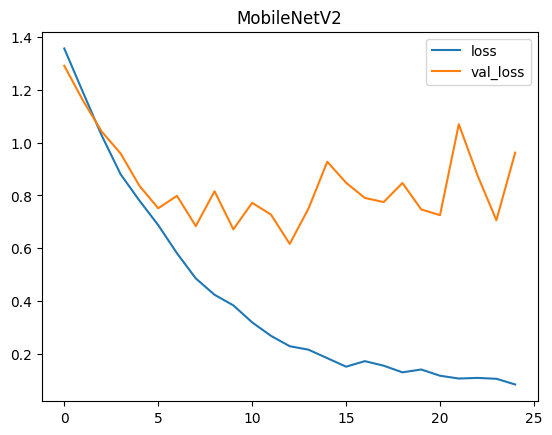

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# loss
fig, ax = plt.subplots()
ax.plot(h_model.history['loss'], label='loss')
ax.plot(h_model.history['val_loss'], label='val_loss')
ax.legend()
plt.title('MobileNetV2')
plt.show()

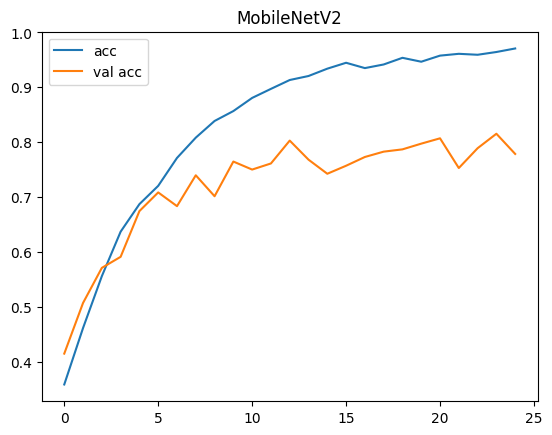

In [ ]:
# accuracies
fig, ax = plt.subplots()
ax.plot(h_model.history['accuracy'], label='acc')
ax.plot(h_model.history['val_accuracy'], label='val acc')
ax.legend()
plt.title('MobileNetV2')
plt.show()

In [ ]:
# Simpan model
model.save(r"C:\Users\Administrator\Documents\RESA\Skripsi\Evaluasi\MobileNetV2.h5")

FileNotFoundError: [Errno 2] Unable to synchronously create file (unable to open file: name = 'C:\Users\Administrator\Documents\RESA\Skripsi\Evaluasi\MobileNetV2.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 302)

In [ ]:
y_preds =  model.predict(X_test)
y_preds

45/45 [==============================] - 6s 124ms/step


array([[2.4483032e-03, 9.9709499e-01, 4.0363398e-04, 5.3092648e-05],
       [3.3759318e-07, 9.9999821e-01, 1.4062535e-06, 4.8111297e-09],
       [1.0144959e-08, 4.2237030e-04, 9.9890864e-01, 6.6893513e-04],
       ...,
       [1.5174287e-03, 9.0107131e-01, 9.7372249e-02, 3.8951712e-05],
       [1.1362879e-05, 9.9998820e-01, 8.7342356e-09, 4.3500486e-07],
       [6.1251758e-06, 4.3283081e-01, 5.2758199e-01, 3.9581083e-02]],
      dtype=float32)

In [ ]:
y_preds_ind = np.argmax(y_preds,axis=1)
y_preds_ind

array([1, 1, 2, ..., 1, 1, 2], dtype=int64)

In [ ]:
qwe=np.argmax(Y_test, axis=1)

In [ ]:
confusion_matrix(qwe,y_preds_ind)

array([[260,  33,  54,  33],
       [  4, 283,  42,   9],
       [  3,  17, 314,  29],
       [ 11,  36,  48, 264]], dtype=int64)

In [ ]:
print(classification_report(qwe,y_preds_ind))

              precision    recall  f1-score   support

           0       0.94      0.68      0.79       380
           1       0.77      0.84      0.80       338
           2       0.69      0.87      0.76       363
           3       0.79      0.74      0.76       359

    accuracy                           0.78      1440
   macro avg       0.79      0.78      0.78      1440
weighted avg       0.80      0.78      0.78      1440



In [ ]:
model.evaluate(X_test, Y_test)

45/45 [==============================] - 6s 125ms/step - loss: 0.9622 - accuracy: 0.7785 - specificity: 0.9289 - sensitivity: 0.7764


[0.9621620178222656,
 0.7784722447395325,
 0.9289352297782898,
 0.7763888835906982]

### 6.3 ROC AUC Curve

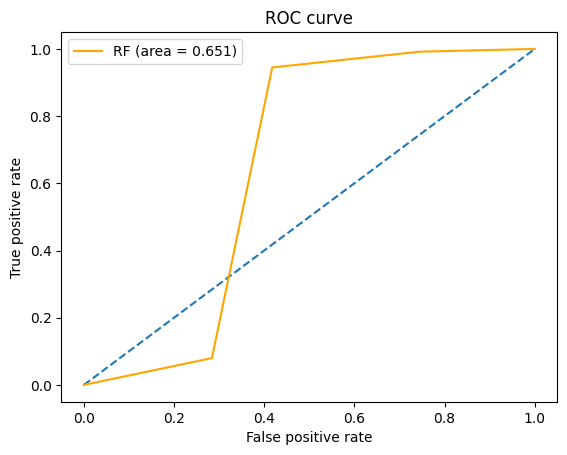

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve(qwe, y_preds_ind, pos_label=2)

auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1],"--")

plt.plot(fpr, tpr, label='RF (area = {:.3f})'.format(auc), color='orange')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Visualization

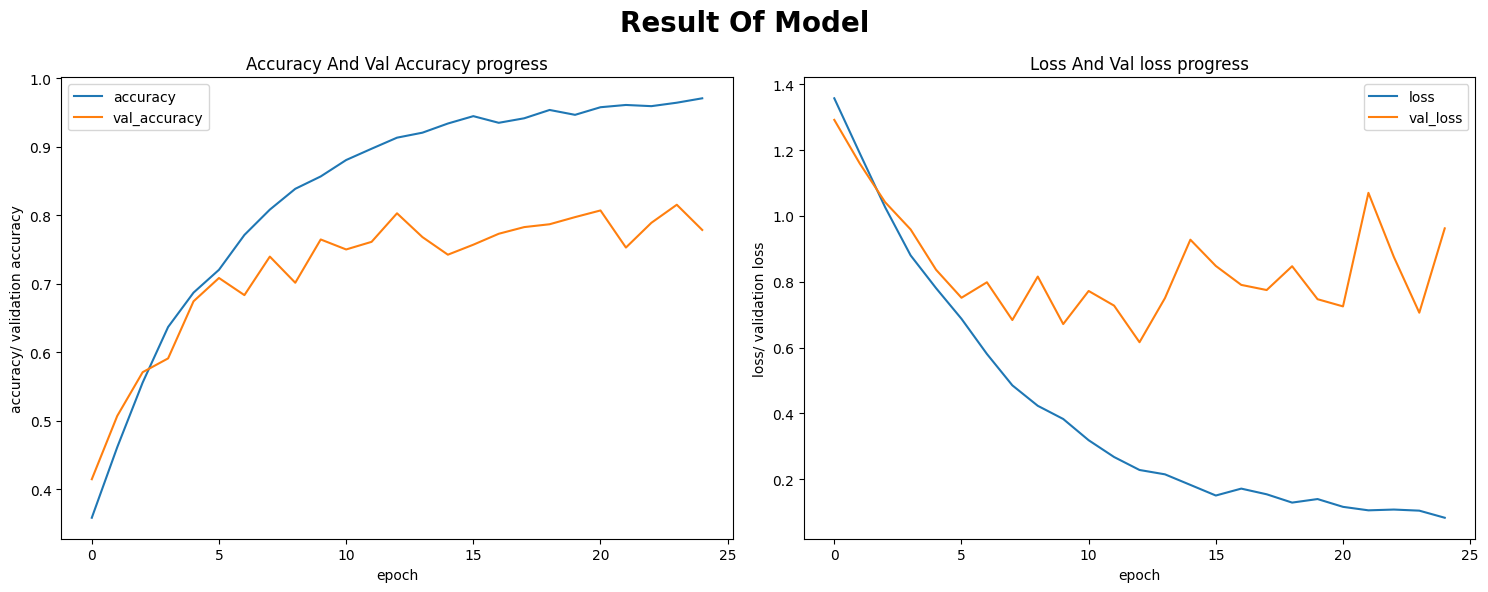

In [ ]:
def Visualize_Result(acc,val_acc,loss, val_loss):
    fig, (ax1, ax2) = plt.subplots(nrows = 1,
                                   ncols = 2,
                                   figsize = (15,6))

    plot1 = ax1.plot(range(0, len(acc)),
                     acc,
                     label = 'accuracy')

    plot2 = ax1.plot(range(0, len(val_acc)),
                     val_acc,
                     label = 'val_accuracy')

    ax1.set(title = 'Accuracy And Val Accuracy progress',
            xlabel = 'epoch',
            ylabel = 'accuracy/ validation accuracy')

    ax1.legend()

    plot3 = ax2.plot(range(0, len(loss)),
                     loss,
                     label = 'loss')
    
    plot4 = ax2.plot(range(0, len(val_loss)),
                     val_loss,
                     label = 'val_loss')
    
    ax2.set(title = 'Loss And Val loss progress',
            xlabel = 'epoch',
            ylabel = 'loss/ validation loss')

    ax2.legend()

    fig.suptitle('Result Of Model', fontsize = 20, fontweight = 'bold')
    fig.savefig(r'D:\Users\RESA\Coding\Evaluasi\Accuracy_Loss_figure_ResNet50.png')
    plt.tight_layout()
    plt.show()

visualize_result = Visualize_Result(h_model.history['accuracy'],h_model.history['val_accuracy'], h_model.history['loss'], h_model.history['val_loss'])

## 7. Cross Validation

In [ ]:
# Set early stopping criteria
pat = 5 
early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1)

# Tentukan model checkpoint callback
model_checkpoint = ModelCheckpoint(r'C:\Users\Administrator\Documents\RESA\Skripsi\Evaluasi\h_MobileNetV2.h5', verbose=1, save_best_only=True)

# Tentukan fungsi untuk fit model
def fit_and_evaluate(X_train, X_test, Y_train, Y_test, EPOCHS=20, BATCH_SIZE=16):
    model = create_model()
    results = model.fit(X_train, Y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                        callbacks=[early_stopping, model_checkpoint], verbose=1, validation_split=0.2)
    print("Val Score: ", model.evaluate(X_test, Y_test))
    return results

### 7.1 Training

In [ ]:
n_folds = 5
epochs = 20
batch_size = 16

# Save the model history after fitting so that we can plot later
model_history = []

for i in range(n_folds):
    print("Training on Fold: ", i + 1)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,
                                                                random_state=np.random.randint(1, 1000, 1)[0])
    model_history.append(fit_and_evaluate(X_train, X_test, Y_train, Y_test, epochs, batch_size))
    print("=======" * 12, end="\n\n\n")

### 7.2 Evaluasi Cross - Validation

In [ ]:
plt.title('Accuracies vs Epochs')
for i in range(len(model_history)):
  plt.plot(model_history[i].history['accuracy'], label=f"Training Fold {i+1}")

plt.legend()
plt.show()
fig.savefig(r'D:\Users\RESA\Coding\Evaluasi\Accuracy_vs_Epoch_MobileNetV2.png')

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Train Accuracy vs Val Accuracy')
plt.plot(model_history[0].history['accuracy'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['accuracy'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_history[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history[2].history['accuracy'], label='Train Accuracy Fold 3', color='green', )
plt.plot(model_history[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")
plt.legend()
plt.show()
fig.savefig(r'D:\Users\RESA\Coding\Evaluasi\TrainAccuracy_vs_ValAccuracy_MobileNetV2.png')

In [ ]:
y_preds =  model.predict(X_test)
y_preds

In [ ]:
y_preds_arg = np.argmax(y_preds,axis=1)
y_preds_arg

In [ ]:
asd = np.argmax(Y_test, axis=1)
asd

In [ ]:
confusion_matrix(asd,y_preds_arg)

In [ ]:
print(classification_report(asd,y_preds_arg))

In [ ]:
def draw_confusion_matrix(true,preds):
    conf_matx = confusion_matrix(true, preds)
    sns.heatmap(conf_matx, annot=True,fmt='g', cmap="viridis")
    plt.show()

In [ ]:
draw_confusion_matrix(asd,y_preds_arg)